In [31]:
from pygooglenews import GoogleNews
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns # Import seaborn

# Set seaborn style
sns.set_theme(style="whitegrid")

In [32]:
FROM = "2023-01-01"
TO = "2023-12-31"
TOPIC = "BUSINESS"

In [33]:
ftse_top_20 = [
    "AZN",   # AstraZeneca
    "HSBA",  # HSBC Holdings
    "SHEL",  # Shell
    "ULVR",  # Unilever
    "RIO",   # Rio Tinto
    "REL",   # RELX
    "BP",    # BP
    "BATS",  # British American Tobacco
    "LSEG",  # London Stock Exchange Group
    "GSK",   # GlaxoSmithKline
    "DGE",   # Diageo
    "GLEN",  # Glencore
    "NG",    # National Grid
    "RR",    # Rolls-Royce Holdings
    "CPG",   # Compass Group
    "BA",    # BAE Systems
    "LLOY",  # Lloyds Banking Group
    "EXPN",  # Experian
    "BARC",  # Barclays
    "RKT"    # Reckitt Benckiser
]


In [34]:
# Convert the news data to a DataFrame
def convert_to_dataframe(news):
    data = []
    for article in news['entries']:
        date = datetime.strptime(article['published'], '%a, %d %b %Y %H:%M:%S %Z')
        title = article['title']
        data.append({'date': date, 'title': title})
    return pd.DataFrame(data)


FETCH_DATA = False # Set to True to fetch new data
if FETCH_DATA:
    gn = GoogleNews(lang="en", country="GB")
    news = gn.search(
        query=" OR ".join(ftse_top_20),
        from_=FROM,
        to_=TO,
    )
    # Create a DataFrame from the news data
    df = convert_to_dataframe(news)
    df['date'] = pd.to_datetime(df['date'])

    # Set the date as the index
    df.set_index('date', inplace=True)
    df.to_csv('data/news_data.csv')
else:
    # Read the CSV file
    df = pd.read_csv('.././data/news_data.csv', parse_dates=['date'])
    df.set_index('date', inplace=True)


In [35]:
# Resample the data to daily frequency and count the number of articles per day
df_daily = df.resample('D').count()
# Reset the index to have 'date' as a column
df_daily.reset_index(inplace=True)

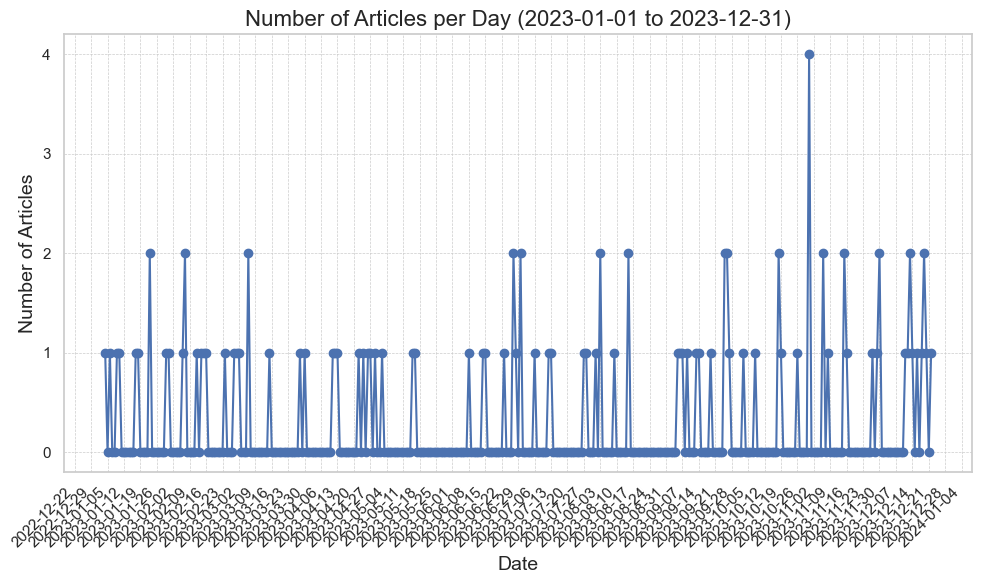

In [36]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the number of articles per day
ax.plot(df_daily['date'], df_daily['title'], marker='o', linestyle='-', color='b')
# Set the title and labels
ax.set_title(f"Number of Articles per Day ({FROM} to {TO})", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Number of Articles", fontsize=14)
# Set the x-axis major locator to show every 7th day
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# Set the x-axis major formatter to show the date in a readable format
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
# Rotate the x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
# Set the y-axis major locator to show a maximum of 10 ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# Set the grid
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
# Set the title and labels
ax.set_title(f"Number of Articles per Day ({FROM} to {TO})", fontsize=16)
# Show the plot
plt.tight_layout()
plt.show()

In [37]:
import yfinance

ftse100 = yfinance.Ticker("^FTSE")
ftse100_data = ftse100.history(
    start=FROM,
    end=TO,
    interval="1d",
    actions=False,
    auto_adjust=True,
    prepost=False,
    proxy=None
)
ftse100_data = ftse100_data[["Close"]]
ftse100_data["Returns"] = ftse100_data["Close"].pct_change()
ftse100_data["Volatility"] = ftse100_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ftse100_data = ftse100_data.dropna()

In [38]:
# Merge the news data and FTSE 100 data on the date index
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.set_index('date', inplace=True)
ftse100_data.reset_index(inplace=True)
ftse100_data['date'] = pd.to_datetime(ftse100_data['Date'])
ftse100_data.set_index('date', inplace=True)
# Convert timezone-aware dates to timezone-naive for consistent merging
ftse100_data_no_tz = ftse100_data.copy()
ftse100_data_no_tz.index = ftse100_data_no_tz.index.tz_localize(None)
merged_data = pd.merge(df_daily, ftse100_data_no_tz, left_index=True, right_index=True, how='inner')
# Reset the index to have 'date' as a column
merged_data.reset_index(inplace=True)
merged_data.drop(columns=['Date'], inplace=True)

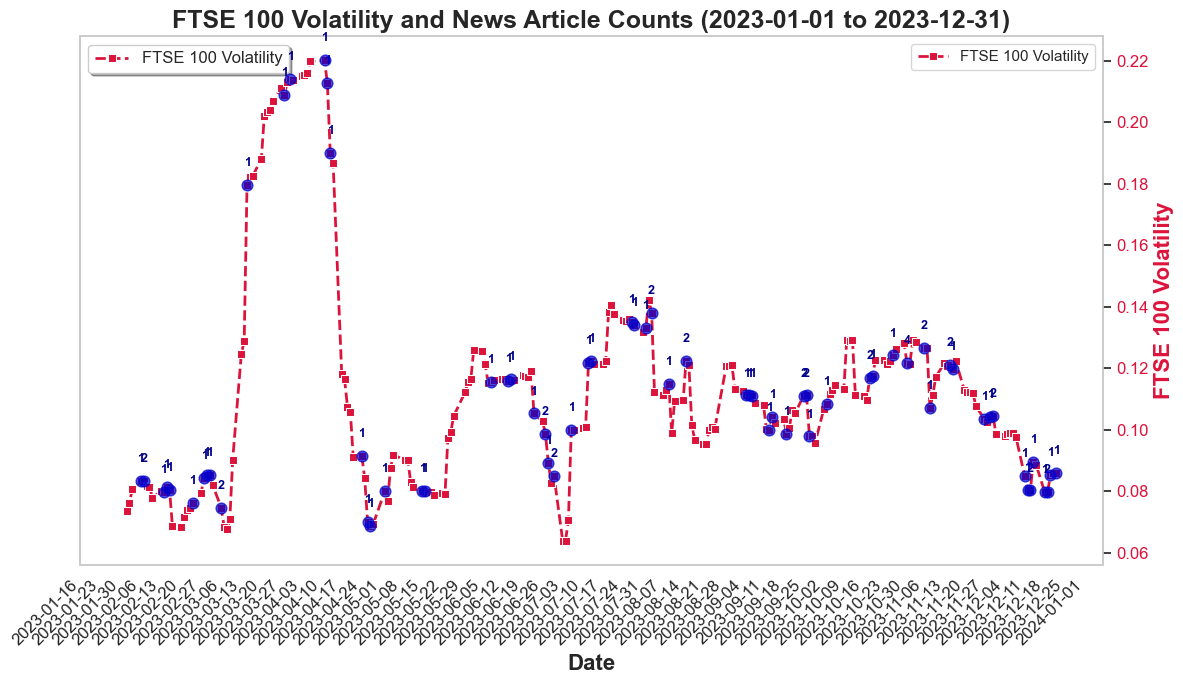

In [40]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7)) # Increased figure size

# Set the title and labels with improved font sizes
ax1.set_title(f"FTSE 100 Volatility and News Article Counts ({FROM} to {TO})", fontsize=18, fontweight='bold')
ax1.set_xlabel("Date", fontsize=16, fontweight='bold')

# Set the x-axis major locator to show every 7th day
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# Set the x-axis major formatter to show the date in a readable format
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
# Rotate the x-axis labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Hide ax1's y-axis as it's no longer plotting a data series directly
ax1.set_yticks([])
# ax1.set_ylabel("") # Clear any potential old label

# Create a second y-axis for the FTSE 100 volatility
ax2 = ax1.twinx()

# Plot the FTSE 100 volatility using seaborn
sns.lineplot(x='date', y='Volatility', data=merged_data, ax=ax2, marker='s', linestyle='--', color='crimson', label='FTSE 100 Volatility', linewidth=2, zorder=1)

# Set the y-axis label for the second y-axis
ax2.set_ylabel("FTSE 100 Volatility", fontsize=16, fontweight='bold', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson', labelsize=12)

# Set the y-axis major locator to show a maximum of 10 ticks
ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))

# Add scatter points and text annotations for news article counts on ax2
# Ensure this loop runs after the volatility line is plotted so get_ylim() is accurate
for index, row in merged_data.iterrows():
    if row['title'] > 0 and pd.notna(row['Volatility']):
        date_to_plot = pd.to_datetime(row['date'])
        volatility_value = row['Volatility']
        article_count = int(row['title'])
        
        # Calculate offset for text based on y-axis range of ax2
        y_min, y_max = ax2.get_ylim()
        text_offset = (y_max - y_min) * 0.03  # 3% of y-axis range, adjust as needed

        # Plot scatter dot for news count indication
        ax2.scatter(date_to_plot, volatility_value, color='mediumblue', s=60, zorder=5, alpha=0.7, label='_nolegend_')
        # Add text annotation for the number of articles
        ax2.text(date_to_plot, volatility_value + text_offset, str(article_count),
                 color='darkblue', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Remove grid lines from ax1 (ax2 will inherit grid from sns.set_theme)
ax1.grid(False) 
ax2.grid(False) # Explicitly turn off for ax2 if whitegrid is not desired on top plot, or rely on theme

# Add legend (primarily for FTSE 100 Volatility line from ax2)
handles, labels = ax2.get_legend_handles_labels()
# Filter out any '_nolegend_' entries from scatter points
filtered_handles = [h for i, h in enumerate(handles) if labels[i] != '_nolegend_']
filtered_labels = [l for l in labels if l != '_nolegend_']
ax1.legend(filtered_handles, filtered_labels, loc='upper left', fontsize=12, frameon=True, shadow=True)

# Show the plot
plt.tight_layout()
plt.show()